In [1]:
%matplotlib inline

训练一个MNIST分类器
=====
## 常规数据集，模型检查点，Fine-tune

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

## 1. 常规数据集
PyTorch 有很多内置的数据集，比如MNIST和CIFAR等。 在本教程内，我们将通过构造一个MNIST的类来展示如何构建一个你自己的数据集。
使用这个链接下载minist的图片[this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true)

In [3]:
class MNIST(Dataset):
    #为MNIST构造一个标准的data loader
    def __init__(self,root,transform=None,preload=False):
        """ 初始化MNIST数据集
        参数:
            - root: 数据集路径
            - tranform: 标准的变换函数
            - preload: 是否预先加载数据到内存中
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        #读取文件名
        for i in range(10):
            #读取 root/i/ 路径下的所有png图片
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) #匹配(filename, label) 
                
        #是否预先加载数据到内存中
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        预先加载数据到内存中
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            #加载图片
            image = Image.open(image_fn)
            #避免打开太多文件的bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
        """ 从数据集中取一个样本
        """
        if self.images is not None:
            #是否预加载了数据
            image = self.images[index]
            label = self.labels[index]
        else:
            #是否按需加载数据
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # 可能会对样本使用变换操作，比如随机剪裁、whitening
        if self.transform is not None:
            image = self.transform(image)
        # 返回图片和标签
        return image, label

    def __len__(self):
        #数据集中样本的总数
        return self.len

In [4]:
# 创建MNIST训练集
# transforms.ToTensor() 会自动将PIL图像转换成[0,1]之间的torch tensors

trainset = MNIST(
    root='mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)
# 使用torch中的dataloader来迭代整个数据集
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# 加载测试集
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)
# 使用torch中的dataloader来迭代整个数据集
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [5]:
print(len(trainset))
print(len(testset))

60000
10000


### 可视化数据集

tensor(3) tensor(8) tensor(4) tensor(4) tensor(0) tensor(2) tensor(7) tensor(9) tensor(2) tensor(7) tensor(6) tensor(9) tensor(6) tensor(6) tensor(1) tensor(9)


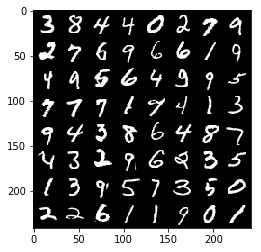

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 显示图片的函数
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# 获得一些随机的训练集图像
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % labels[j] for j in range(16)))

In [7]:
# 如果有GPU则使用GPU，否则使用CPU
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### 定义一个卷积网络


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 训练网络

In [9]:
def train(epoch, log_interval=100):
    model.train()  # 设定training模式
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [10]:
def test():
    model.eval()  # 设定evaluation模式
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # batch的loss求和
            pred = output.max(1, keepdim=True)[1] # 得到最大log-probability的索引
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [11]:
train(5)  # 训练5个epochs应该可以让你达到大约97%的准确率

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290318
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.316085
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.284893
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.280910
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.222962
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.063124
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.928669
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.533078
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.378734
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.287658

Test set: Average loss: 0.7227, Accuracy: 8182/10000 (82%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.586974
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.396407
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.664116
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.288208
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.380612
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.244317
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.311487
Train Epoch: 1 [48768/60000 (81%)]	Loss: 0.426600
Train Epoch: 1 [55168/60000 (92%)]	Loss: 0.1607

## 2. 模型的保存 (model checkpointing)

现在我们有了一个训练好的模型

显然我们不想每次使用的时候都重新训练

尤其是当训练一个超大型的模型时，可能你会希望能够定期保存模型的检查点，以便于意外出现后退回到上一个检查点，或者仅仅是想测试不同训练模型的表现

PyTorch中的Model checkpointing非常简单。首先，我们定义一个可以保存模型到磁盘中的辅助函数

In [12]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [13]:
# 创建一个全新的模型
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()


Test set: Average loss: 2.3039, Accuracy: 1009/10000 (10%)



### 定义具有model checkpointing的训练迭代

In [14]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # 设置training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            #下边的两行代码是在实现checkpointing
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # 保存最终模型。下面这一行代码和上面那两行是之前train()函数没有的
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [15]:
train_save(5, 500, 100)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309425
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.311844
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.285262
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.291898
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.272247
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.226420
model saved to mnist-500.pth
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.003182
Train Epoch: 0 [44800/60000 (75%)]	Loss: 1.789296
Train Epoch: 0 [51200/60000 (85%)]	Loss: 1.462778
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.058149

Test set: Average loss: 0.7510, Accuracy: 8155/10000 (82%)

Train Epoch: 1 [3968/60000 (7%)]	Loss: 0.547947
model saved to mnist-1000.pth
Train Epoch: 1 [10368/60000 (17%)]	Loss: 0.438827
Train Epoch: 1 [16768/60000 (28%)]	Loss: 0.402794
Train Epoch: 1 [23168/60000 (39%)]	Loss: 0.447797
Train Epoch: 1 [29568/60000 (49%)]	Loss: 0.228236
Train Epoch: 1 [35968/60000 (60%)]	Loss: 0.514648
model saved to mnist-1500.pth
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.437881
Train Ep

In [16]:
# 创建一个新模型
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 从最终检查点加载
load_checkpoint('mnist-4690.pth', model, optimizer)
# accuracy应该就是最终模型的结果
test()

model loaded from mnist-4690.pth

Test set: Average loss: 0.1130, Accuracy: 9657/10000 (97%)



## 3. 模型Fine-tune

有时我们希望在预训练模型的基础上fine-tune，而不是从头开始。

比如，有时我们希望在全新的自然图像数据集上训练模型。

为了获得最佳性能，我们可以从一个ImageNet预训练好的模型开始，并对模型进行微调。

PyTorch中fine-tune模型是非常容易的！

首先，让我们看看在checkpoint中都保存了什么

In [17]:
# state dict中保存了什么？
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


### Finetune全连接层

现在我们想要从checkpoint中加载卷积层，再训练全连接层。
我们可以通过加载特定state dict的子集来实现

In [18]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    #如果名字中有'conv'，则添加到states_to_load列表中
    if name.startswith('conv'):
        states_to_load[name] = param

# 构建一个新的state dict，其中我们我们希望从checkpoint加载的层会从checkpoint加载参数
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
train(1)  # 训练一个epoch即可达到93%准确率

Train Epoch: 0 [0/60000 (0%)]	Loss: 3.266330
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.718857
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.620336
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.607034
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.672607
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.520620
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.701537
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.444657
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.439578
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.386246

Test set: Average loss: 0.1720, Accuracy: 9498/10000 (95%)



### 在另一个不同模型中加载预训练权重

我们甚至可以再另一个不同模型中加载卷积层预训练的权重

In [20]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# 构造一个字典，其中想要导入预训练权重的层会使用checkpoint中的值

model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)

In [22]:
train(1)  # 训练一个epoch就会达到93%准确率

Train Epoch: 0 [0/60000 (0%)]	Loss: 5.529094
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.472251
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.519664
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.519803
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.271912
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.238663
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.333680
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.303371
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.273649
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.312762

Test set: Average loss: 0.1689, Accuracy: 9499/10000 (95%)

